In [ ]:
# Uncomment before running for first time.
#!pip install keras-tuner

In [ ]:
# Copied imports from main file.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import math

from kerastuner.tuners import BayesianOptimization
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, TimeDistributed, Reshape, Bidirectional, BatchNormalization, Attention
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l1_l2

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer

<ipython-input-2-9228d51e5c4d>:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


Define generator for calculating technical indicators

In [ ]:
# Define the Generator class for feature calculations
class Generator:
    def __init__(self):
        pass

    def SMA(self, data, windows):
        return data.rolling(window=windows).mean()

    def EMA(self, data, windows):
        return data.ewm(span=windows).mean()

    def MACD(self, data, long, short, windows):
        short_ema = data.ewm(span=short).mean()
        long_ema = data.ewm(span=long).mean()
        macd = short_ema - long_ema
        signal = macd.ewm(span=windows).mean()
        return signal

    def RSI(self, data, windows):
        delta = data.diff(1)
        up = delta.clip(lower=0)
        down = -delta.clip(upper=0)
        avg_up = up.rolling(window=windows).mean()
        avg_down = down.rolling(window=windows).mean()
        rs = avg_up / avg_down
        rsi = 100.0 - (100.0 / (1.0 + rs))
        return rsi

    def atr(self, data_high, data_low, windows):
        range_ = data_high - data_low
        return range_.rolling(window=windows).mean()

    def bollinger_band(self, data, windows):
        sma = data.rolling(window=windows).mean()
        std = data.rolling(window=windows).std()
        upper_band = sma + 2 * std
        lower_band = sma - 2 * std
        return upper_band, lower_band

    def rsv(self, data, windows):
        min_ = data.rolling(window=windows).min()
        max_ = data.rolling(window=windows).max()
        return (data - min_) / (max_ - min_) * 100

    def ichimoku_cloud(self, data_high, data_low, data_close):
        high_9 = data_high.rolling(window=9).max()
        low_9 = data_low.rolling(window=9).min()
        conversion_line = (high_9 + low_9) / 2
        high_26 = data_high.rolling(window=26).max()
        low_26 = data_low.rolling(window=26).min()
        base_line = (high_26 + low_26) / 2
        leading_span_a = (conversion_line + base_line) / 2
        leading_span_b = (data_high.rolling(window=52).max() + data_low.rolling(window=52).min()) / 2
        return conversion_line, base_line, leading_span_a, leading_span_b

    def vwap(self, data_volume, data_high, data_low, data_close):
        typical_price = (data_high + data_low + data_close) / 3
        vwap = (typical_price * data_volume).cumsum() / data_volume.cumsum()
        return vwap

    def chaikin_money_flow(self, data_high, data_low, data_close, data_volume, windows):
        money_flow_multiplier = ((data_close - data_low) - (data_high - data_close)) / (data_high - data_low)
        money_flow_volume = money_flow_multiplier * data_volume
        return money_flow_volume.rolling(window=windows).sum() / data_volume.rolling(window=windows).sum()

    def on_balance_volume(self, data_close, data_volume):
        return data_volume.where(data_close > data_close.shift(1), -data_volume).cumsum()

    def commodity_channel_index(self, data_high, data_low, data_close, windows):
        typical_price = (data_high + data_low + data_close) / 3
        sma = typical_price.rolling(window=windows).mean()
        mean_deviation = (typical_price - sma).abs().rolling(window=windows).mean()
        cci = (typical_price - sma) / (0.015 * mean_deviation)
        return cci

    def stochastic_oscillator(self, data_high, data_low, data_close, windows):
        low_min = data_low.rolling(window=windows).min()
        high_max = data_high.rolling(window=windows).max()
        k = (data_close - low_min) / (high_max - low_min) * 100
        return k

# Initialize Generator
gen = Generator()

Define date range for fetching dataset.

In [ ]:
end = dt.datetime(2024,2,2)
start = dt.datetime(2017,11,11)
start, end

(datetime.datetime(2017, 11, 11, 0, 0), datetime.datetime(2024, 2, 2, 0, 0))

Fetch data.

In [ ]:
asset = ['ETH-USD']
yf.pdr_override()
df = yf.download(asset, start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


Calulate technical indicators

In [ ]:
# Calaculate and append the the technical indicators to the df dataframe
df['7ma'] = gen.EMA(df['Close'], 7)
df['14ma'] = gen.EMA(df['Close'], 14)
df['21ma'] = gen.EMA(df['Close'], 21)
df['7macd'] = gen.MACD(df['Close'], 26, 12, 9)
df['14macd'] = gen.MACD(df['Close'], 26, 12, 9)
df['7rsi'] = gen.RSI(df['Close'], 7)
df['14rsi'] = gen.RSI(df['Close'], 14)
df['21rsi'] = gen.RSI(df['Close'], 21)
df['7atr'] = gen.atr(df['High'], df['Low'], 7)
df['14atr'] = gen.atr(df['High'], df['Low'], 14)
df['21atr'] = gen.atr(df['High'], df['Low'], 21)
df['7upper'], df['7lower'] = gen.bollinger_band(df['Close'], 7)
df['14upper'], df['14lower'] = gen.bollinger_band(df['Close'], 14)
df['21upper'], df['21lower'] = gen.bollinger_band(df['Close'], 21)
df['7rsv'] = gen.rsv(df['Close'], 7)
df['14rsv'] = gen.rsv(df['Close'], 14)
df['21rsv'] = gen.rsv(df['Close'], 21)
df['ichimoku_a'], df['ichimoku_b'], df['lead_span_a'], df['lead_span_b'] = gen.ichimoku_cloud(df['High'], df['Low'], df['Close'])
df['vwap'] = gen.vwap(df['Volume'], df['High'], df['Low'], df['Close'])
df['cmf'] = gen.chaikin_money_flow(df['High'], df['Low'], df['Close'], df['Volume'], 21)
df['obv'] = gen.on_balance_volume(df['Close'], df['Volume'])
df['cci'] = gen.commodity_channel_index(df['High'], df['Low'], df['Close'], 14)
df['stochastic'] = gen.stochastic_oscillator(df['High'], df['Low'], df['Close'], 14)

Drop any null values

In [ ]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume,7ma,14ma,21ma,7macd,...,21rsv,ichimoku_a,ichimoku_b,lead_span_a,lead_span_b,vwap,cmf,obv,cci,stochastic
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,755.757019,782.530029,742.004028,772.640991,772.640991,2595760128,751.710506,734.906693,708.693695,59.805841,...,69.108046,702.087494,648.177490,675.132492,590.067978,609.523669,0.244660,24759511744,14.183425,67.679239
2018-01-02,772.346008,914.830017,772.346008,884.443970,884.443970,5783349760,784.893880,754.855137,724.773908,59.462030,...,100.000000,800.030518,668.598511,734.314514,606.671509,622.153204,0.220244,30542861504,139.811334,91.811192
2018-01-03,886.000000,974.471008,868.450989,962.719971,962.719971,5093159936,829.350410,782.582664,746.531963,61.447777,...,100.000000,829.851013,701.992508,765.921761,640.748001,635.607182,0.250871,35636021440,237.514605,97.271699
2018-01-04,961.713013,1045.079956,946.085999,980.921997,980.921997,6502859776,867.243312,809.038010,767.953453,64.935273,...,100.000000,865.155487,737.296982,801.226234,680.921478,654.077608,0.229927,42138881216,282.609241,87.202142
2018-01-05,975.750000,1075.390015,956.325012,997.719971,997.719971,6683149824,899.862480,834.203933,788.942243,69.297229,...,100.000000,880.310516,757.247009,818.778763,699.498001,672.129585,0.164653,48822031040,215.990586,83.132369


Prepare data for LSTM model.

In [ ]:
# Data Reshaping and Normalization
def prepare_data(df, target_column, n_steps):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    df_scaled = scaler.fit_transform(df)

    X, y = [], []
    for i in range(n_steps, len(df_scaled)):
        X.append(df_scaled[i-n_steps:i])
        y.append(df_scaled[i][df.columns.get_loc(target_column)])
    X, y = np.array(X), np.array(y)
    return X, y

n_steps = 100  # Number of timesteps per sample
X, y = prepare_data(df, 'Close', n_steps)

# Split data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Define and build LSTM model with Bayesian Optimisation

In [ ]:
n_features = X_train.shape[2]

def build_model(hp):
    model = Sequential()
    # Adjust the input_shape parameter to match the number of features (35 in this case)
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.2, step=0.05)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.2, step=0.05)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# NAS Setup
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='nas_ETH',
    project_name='ETH_price_prediction'
)

Reloading Tuner from nas_ETH/ETH_price_prediction/tuner0.json


In [ ]:
# Training
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the optimal hyperparameters, trials were set low to decrease computation time. Good practice calls for a higher value for robusteness.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
54/54 [==============================] - 5s 35ms/step - loss: 0.0334 - val_loss: 3.2085e-04
Epoch 2/50
54/54 [==============================] - 1s 21ms/step - loss: 0.0014 - val_loss: 6.3959e-04
Epoch 3/50
54/54 [==============================] - 1s 21ms/step - loss: 9.5877e-04 - val_loss: 3.4704e-04
Epoch 4/50
54/54 [==============================] - 1s 21ms/step - loss: 8.2005e-04 - val_loss: 5.7867e-04
Epoch 5/50
54/54 [==============================] - 1s 22ms/step - loss: 8.1590e-04 - val_loss: 0.0014
Epoch 6/50
54/54 [==============================] - 1s 22ms/step - loss: 0.0013 - val_loss: 3.7929e-04
Epoch 7/50
54/54 [==============================] - 1s 21ms/step - loss: 6.4182e-04 - val_loss: 5.2293e-04
Epoch 8/50
54/54 [==============================] - 1s 21ms/step - loss: 7.4844e-04 - val_loss: 3.0609e-04
Epoch 9/50
54/54 [==============================] - 1s 21ms/step - loss: 6.1570e-04 - val_loss: 4.0767e-04
Epoch 10/50
54/54 [==============================] - 

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 352)          546304    
                                                                 
 dropout_4 (Dropout)         (None, 100, 352)          0         
                                                                 
 lstm_5 (LSTM)               (None, 352)               992640    
                                                                 
 dropout_5 (Dropout)         (None, 352)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 353       
                                                                 
Total params: 1539297 (5.87 MB)
Trainable params: 1539297 (5.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Evaluate model on metrics.

In [ ]:
# Predicting the values using the trained model
y_pred = model.predict(X_test)

# Calculating Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculating Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculating Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculating Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)

# Calculating R2 Score
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

14/14 [==============================] - 1s 12ms/step
Mean Squared Error (MSE): 0.0005025038906957086
Root Mean Squared Error (RMSE): 0.022416598553208482
Mean Absolute Error (MAE): 0.018361947770640312
Mean Absolute Percentage Error (MAPE): 21.410950677959836
R2 Score: 0.8728672471671064


Plot Actual versus Predicted Values to visualise if the model has trained effectively.

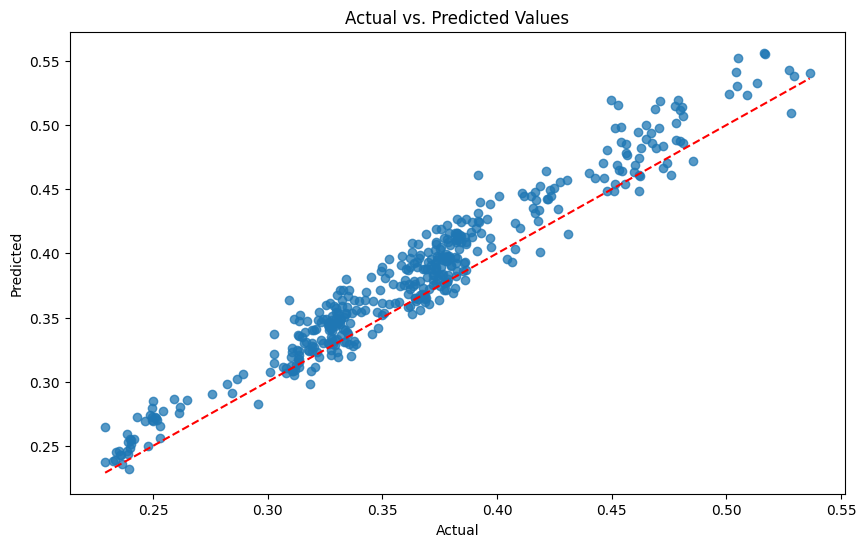

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.75)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()